In [1]:
import os
import itertools
from PIL import Image
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [7]:
def get_data(path_original,path_tampered):
    images = []

    for file in os.listdir(path_original):
        try:
            if file.endswith('jpg'):
                if int(os.stat(path_original + file).st_size) > 1000:
                    line = path_original + file  + ',0\n'
                    images.append(line)
        except:
            print(path_original+file)
        
    for file in os.listdir(path_tampered):
        try:
            if file.endswith('jpg'):
                if int(os.stat(path_tampered + file).st_size) > 1000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
            if file.endswith('tif'):
                if int(os.stat(path_tampered + file).st_size) > 1000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        except:
            print(path_tampered+file)
    return images

def make_dataset(images):
    image_name = []
    label = []
    for i in range(len(images)):
        image_name.append(images[i][0:-3])
        label.append(images[i][-2])
    dataset = pd.DataFrame({'image':image_name,'class_label':label})
    dataset.to_csv('dataset_CASIA2.csv',index=False)
    dataset = pd.read_csv('dataset_CASIA2.csv')
    return dataset

def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    return ela_im


def make_vector(dataset):
    X = []
    Y = []
    for index, row in dataset.iterrows():
        X.append(array(convert_to_ela_image(row[0], 90).resize((60, 60))).flatten() / 255.0)
        Y.append(row[1])
    X = np.array(X)
    X = X.reshape(-1, 60, 60, 3)
    Y = to_categorical(Y, 2)
    return X,Y

def neural_network_model(X,Y):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
    X = X.reshape(-1,1,1,1)
    
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu', input_shape = (60,60,3)))
    model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(60, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    
    optimizer = Adam()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    epochs = 12
    batch_size = 128
    history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,validation_data = (X_val, Y_val), verbose = 2)
    model.save('trained.h5')
    
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred,axis = 1)
    Y_true = np.argmax(Y_val,axis = 1) 

    score = metrics.precision_score(Y_true,y_pred, average= "weighted")
    print("Precision score: {}".format(score))
    score = metrics.recall_score(Y_true, y_pred, average= "weighted")
    print("Recall score: {}".format(score))
    score_f1 = metrics.f1_score(Y_true, y_pred, average= "weighted")
    print("F1 score: {}".format(score_f1))
    
    cm = confusion_matrix(Y_true, y_pred)
    print('Confusion matrix:\n',cm)
    return history

In [3]:
path_original = 'casia/CASIA2/Au/'
path_tampered = 'casia/CASIA2/Tp/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)
images = get_data(path_original, path_tampered)
dataset = make_dataset(images)
X,Y = make_vector(dataset)
neural_network_model(X,Y)

Epoch 1/10
100/100 - 32s - loss: 0.4903 - accuracy: 0.7542 - val_loss: 0.4067 - val_accuracy: 0.8370
Epoch 2/10
100/100 - 33s - loss: 0.3877 - accuracy: 0.8537 - val_loss: 0.3598 - val_accuracy: 0.8483
Epoch 3/10
100/100 - 29s - loss: 0.3537 - accuracy: 0.8613 - val_loss: 0.3324 - val_accuracy: 0.8636
Epoch 4/10
100/100 - 30s - loss: 0.3279 - accuracy: 0.8725 - val_loss: 0.3156 - val_accuracy: 0.8709
Epoch 5/10
100/100 - 29s - loss: 0.3125 - accuracy: 0.8793 - val_loss: 0.3054 - val_accuracy: 0.8757
Epoch 6/10
100/100 - 30s - loss: 0.2964 - accuracy: 0.8829 - val_loss: 0.3051 - val_accuracy: 0.8705
Epoch 7/10
100/100 - 29s - loss: 0.2834 - accuracy: 0.8904 - val_loss: 0.3588 - val_accuracy: 0.8454
Epoch 8/10
100/100 - 28s - loss: 0.2966 - accuracy: 0.8837 - val_loss: 0.2996 - val_accuracy: 0.8737
Epoch 9/10
100/100 - 27s - loss: 0.2626 - accuracy: 0.8972 - val_loss: 0.3207 - val_accuracy: 0.8680
Epoch 10/10
100/100 - 28s - loss: 0.2509 - accuracy: 0.9009 - val_loss: 0.3004 - val_accura

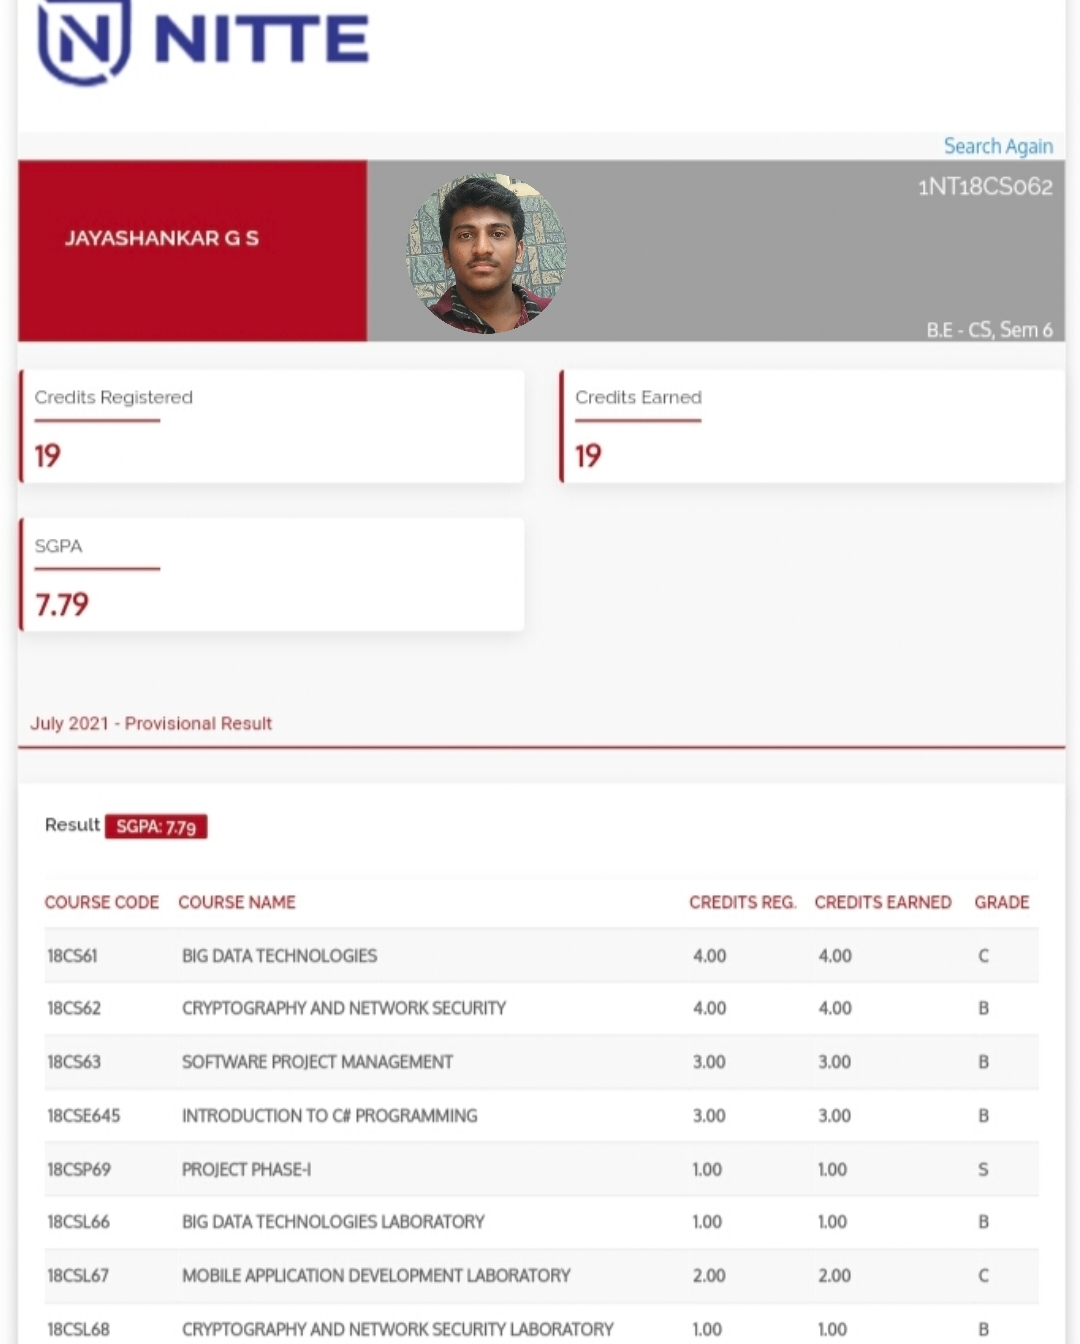

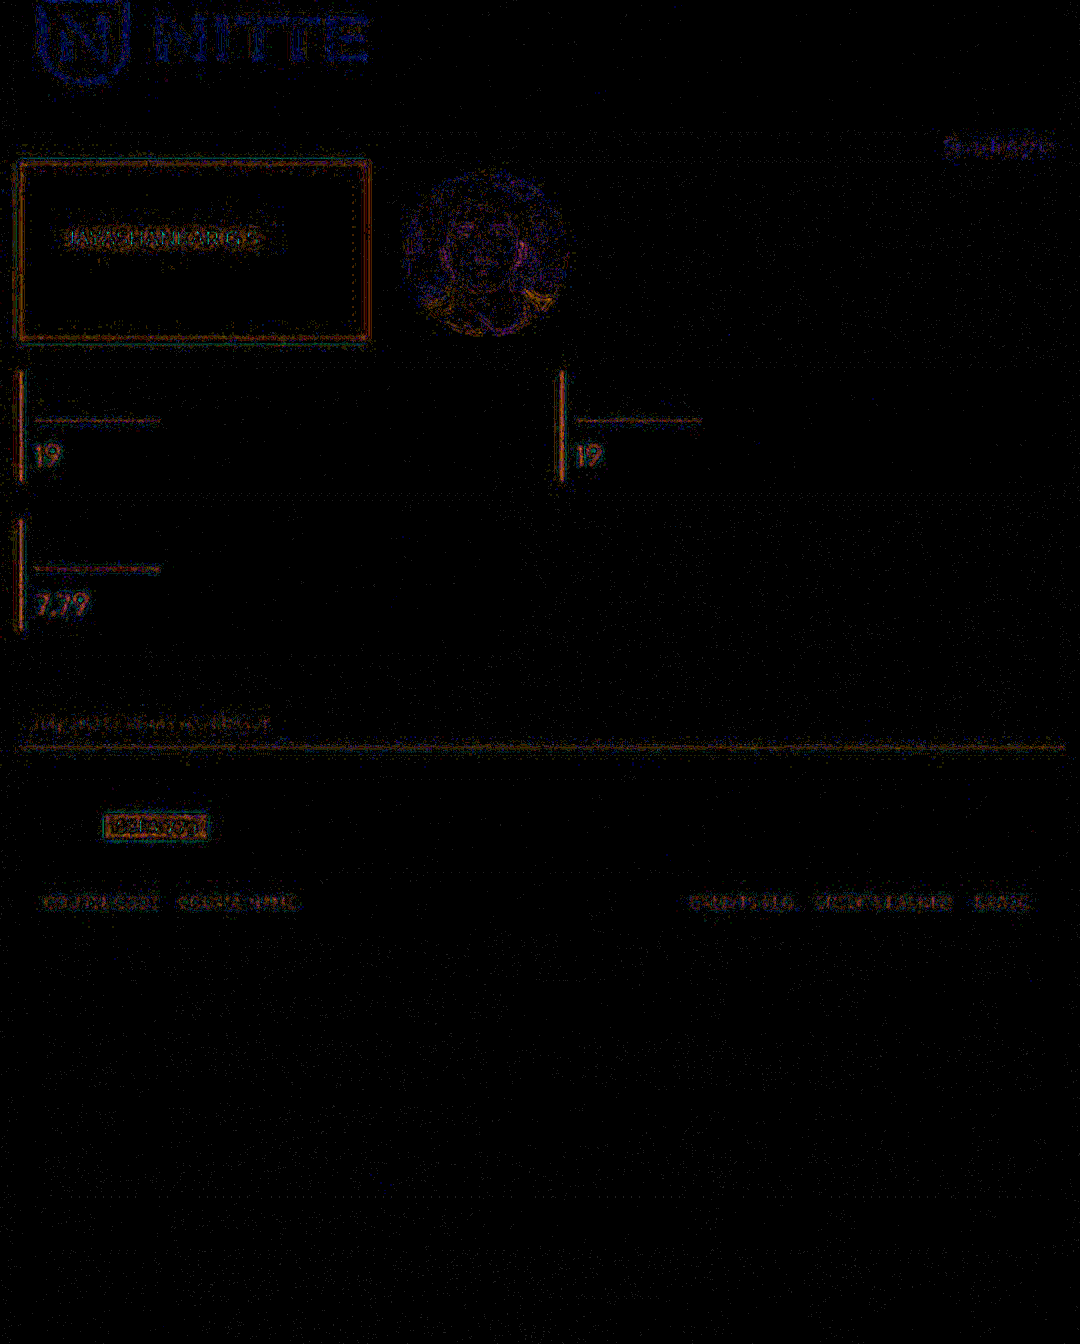

In [8]:
from tensorflow.keras.models import load_model
trained_model = load_model('trained.h5')

orig_img = Image.open("tempresaved.jpg")
display(orig_img)
convert_to_ela_image("tempresaved.jpg",100)

In [9]:
valid = []
valid.append(np.array(convert_to_ela_image("tempresaved.jpg",100).resize((60, 60))).flatten() / 255.0)
valid = np.array(valid)
valid = valid.reshape(-1, 60, 60, 3)
val_test = trained_model.predict(valid)
val_test = np.argmax(val_test,axis = 1)
print(val_test)

[1]


In [5]:
from tensorflow.keras.models import load_model
trained_model = load_model('trained.h5')
trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 56, 56, 16)        1216      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 16)        6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                649020    
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)               